<a href="https://colab.research.google.com/github/snekadhanabal/Copy-of-project/blob/main/Copy_of_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
df = pd.read_csv('emotion.csv')
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Comment,100000,401,❤,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anonymized Author,100000,100000,38cd3642cbb1a148e36b5c129d91eb658d6c53c236a668...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Published At,100000,403,2024-02-18T00:20:42Z,997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Likes,100000.0,NaN,NaN,NaN,52.22723,310.010713,0.0,0.0,2.0,11.0,79514.0
Reply Count,100000.0,NaN,NaN,NaN,2.38692,7.695083,0.0,0.0,0.0,1.0,750.0


Number of comments with the same text,Number of unique comment contents that have this number of repetitions
1,298
2,1
5,1
128,1
324,1
545,1
992,1
997,96
1994,1


<Axes: xlabel='Unique comment', ylabel='Repetition count'>

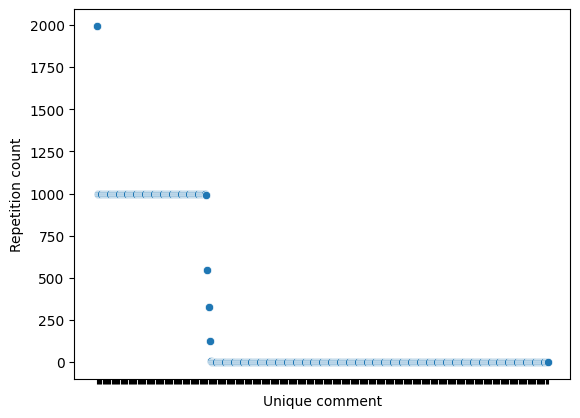

In [ ]:
unique_comment_dist = df.groupby('Comment')['Anonymized Author'].count().sort_values(ascending=False)
uc = np.unique(unique_comment_dist.values, return_counts=True)
uc_df = pd.DataFrame({'Number of comments with the same text':uc[0], 'Number of unique comment contents that have this number of repetitions':uc[1]})

from IPython.display import display, HTML
display(HTML(uc_df.to_html(index=False)))

_ = sns.scatterplot(unique_comment_dist)
_.set_xticklabels([])
_.set_xlabel('Unique comment')
_.set_ylabel('Repetition count')
_

In [ ]:
df['DEV__IsBotComment'] = df['Comment'].isin(unique_comment_dist[unique_comment_dist > 1].index)
df['DEV__IsBotComment'].value_counts()

,count
DEV__IsBotComment,
True,99702
False,298


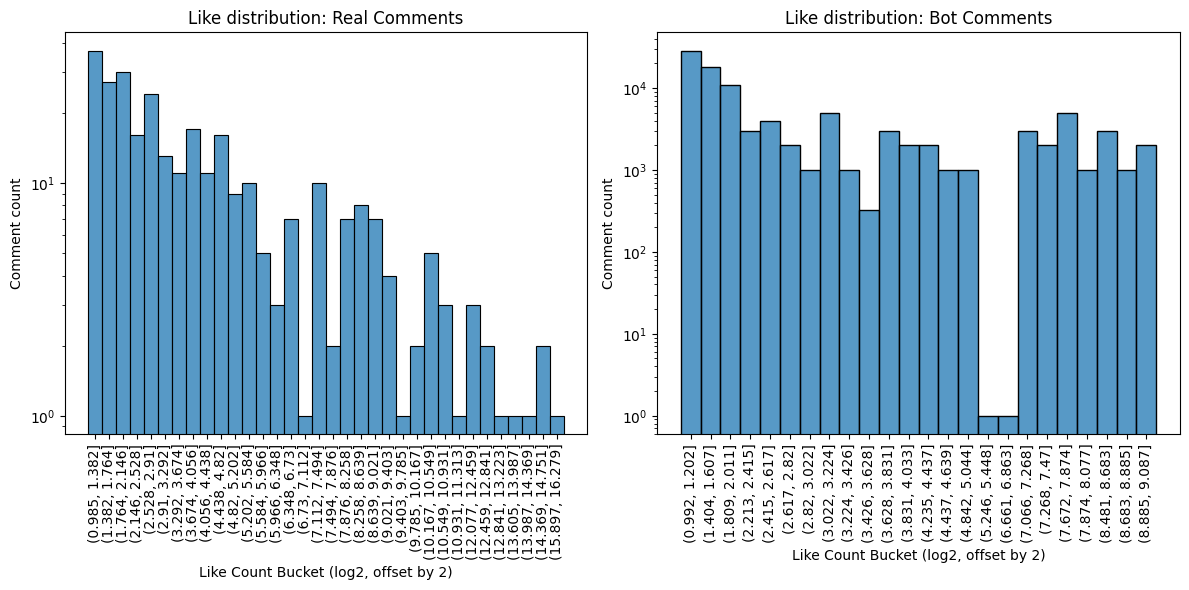

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Real comment histogram
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bucketed_like_counts = pd.cut(np.log2(df[~df['DEV__IsBotComment']]['Likes'].sort_values() + 2), bins=40).astype(str) # Offset by 2 to prevent log of zero.
    sns.histplot(bucketed_like_counts, ax=axs[0]) # Plot on the first subplot
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Like Count Bucket (log2, offset by 2)')
    axs[0].set_ylabel('Comment count')
    axs[0].set_title('Like distribution: Real Comments')
# Bot comment histogram
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    bucketed_like_counts = pd.cut(np.log2(df[df['DEV__IsBotComment']]['Likes'].sort_values() + 2), bins=40).astype(str) # Offset by 2 to prevent log of zero.
    sns.histplot(bucketed_like_counts, ax=axs[1]) # Plot on the second subplot
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Like Count Bucket (log2, offset by 2)')
    axs[1].set_ylabel('Comment count')
    axs[1].set_title('Like distribution: Bot Comments')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [ ]:
df[~df['DEV__IsBotComment']]['Likes'].describe(percentiles=[.25, .75, .9, .95, .99]).rename('Likes on real comments')

,Likes on real comments
count,298.000000
mean,766.218121
std,5224.981883
min,0.000000
25%,2.000000
50%,8.000000
75%,52.500000
90%,477.200000
95%,1414.650000
99%,19898.090000


In [ ]:
df[df['DEV__IsBotComment']]['Likes'].describe(percentiles=[.25, .75, .9, .95, .99]).rename('Likes on bot comments')

,Likes on bot comments
count,99702.000000
mean,50.093178
std,116.362272
min,0.000000
25%,0.000000
50%,2.000000
75%,11.000000
90%,214.000000
95%,389.000000
99%,471.000000


In [ ]:
df_gen = df[~df['DEV__IsBotComment']].drop(['DEV__IsBotComment', 'Published At', 'Anonymized Author'], axis=1)
df_bot = df[ df['DEV__IsBotComment']].drop(['DEV__IsBotComment', 'Published At', 'Anonymized Author'], axis=1)
df_bot_unique = df_bot.groupby('Comment').agg(['mean', 'count'])
df_bot_unique_df = pd.DataFrame({'Likes': df_bot_unique['Likes']['mean'], 'Reply Count': df_bot_unique['Reply Count']['mean']}).reset_index()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Kaggle bug. It fails to run otherwise.
import subprocess
wordnet_path = '/usr/share/nltk_data/corpora/wordnet.zip'
command = f"unzip {wordnet_path} -d /usr/share/nltk_data/corpora/"
subprocess.run(command.split())
nltk.data.path.append('/usr/share/nltk_data')

# Verify wordnet download
from nltk.corpus import wordnet as wn
print(wn.ensure_loaded())
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define the preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


None


NameError: name 'df_gen_res' is not defined

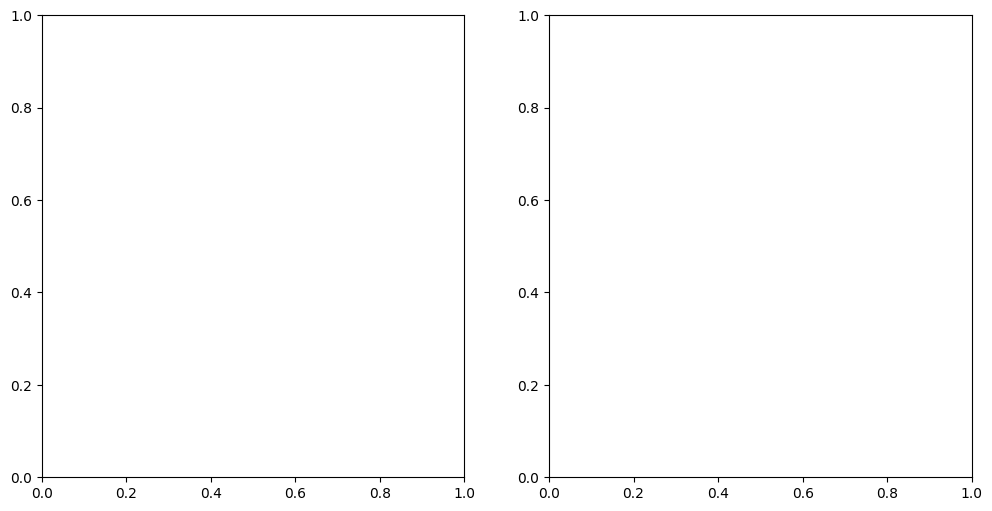

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    sns.histplot(df_gen_res['DEV__Sentiment__compound'], ax=axs[0], bins=20)
    axs[0].set_xlabel('Real comment sentiment')
    axs[0].set_ylabel('Count (unique)') # Solidarity with second plot.
    axs[0].set_xlim(-1, 1)

    sns.histplot(df_bot_res['DEV__Sentiment__compound'], ax=axs[1], bins=15)
    axs[1].set_xlabel('Bot comment sentiment')
    axs[1].set_ylabel('Count (unique)') # We do not care about the duplicate comments here.
    axs[1].set_xlim(-1, 1)

plt.tight_layout()
plt.show()